In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from itertools import cycle
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import cv2

import time
import os
from pathlib import Path
import glob
from tqdm.notebook import tqdm, tnrange
import gc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# from fastai.vision.all import *
from modules.dataset import *
from modules.lovasz_loss import *
from modules.metrics import *
from modules.utils import *

import wandb
from fastai.callback.wandb import *
import segmentation_models_pytorch as smp

from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR

from albumentations import *
from albumentations.pytorch import ToTensorV2

In [2]:
import yaml
cfg_name = 'train_cfg.yml'
with open(f'cfg/{cfg_name}') as f:
        # use safe_load instead load
        cfg = yaml.safe_load(f)

bs = cfg['bs']
nfolds = cfg['nfolds']
fold = cfg['fold']
SEED = cfg['SEED']
TRAIN = cfg['TRAIN']
MASKS = cfg['MASKS']
LABELS = cfg['LABELS']
EXPERIMENT_NAME = cfg['EXPERIMENT_NAME']
NUM_WORKERS = cfg['NUM_WORKERS']
EPOCHS = cfg['EPOCHS']
DEVICE = cfg['DEVICE']
save_root = f'../experiments/{EXPERIMENT_NAME}'

try:
        os.mkdir(save_root)
except:
        print('Folder exists')

In [3]:
from modules.augs import *

def symmetric_lovasz(outputs, targets):
    return 0.5*(lovasz_hinge(outputs, targets) + lovasz_hinge(-outputs, 1.0 - targets))

def get_aug_a4(p=1.0):
    pass
    return 

def get_aug_selection(p=1.0):
    return Compose([
        #stain_aug(normalizer, T, 0.6, 0.7, 0.7)
        #HueSaturationValue(25, 25, 25, p=1),
        # ColorJitter(p=1),
        # GaussianBlur(p=1),
        stain_aug(normalizer, T, 1.0, 0.35, 0.35, type='element_perturb'),
        # OneOf([
        #     stain_norm_as_aug(pas_normalizer, T, 1),    
        #     stain_norm_as_aug(he_normalizer, T, 1),
        # ], p=1),
        # RandomBrightnessContrast((-0.1, 0.1), 0.2, p=1)
    ], p=p)

In [4]:
# # example of train images with masks
# ds = hpa_hubmap_data_he(fold=fold, train=True, tfms=get_aug_a1())
# dl = DataLoader(ds, batch_size=8, shuffle=False, num_workers=NUM_WORKERS)
# imgs, masks, he_matrices = next(iter(dl))

# plt.figure(figsize=(16, 16))
# for i,(img,mask) in enumerate(zip(imgs,masks)):
#     img = ((img.permute(1,2,0))*255.0).numpy().astype(np.uint8)
#     plt.subplot(2, 4, i+1)
#     plt.imshow(img,vmin=0,vmax=255)
#     #plt.imshow(mask.squeeze().numpy(), alpha=0.1, cmap='gray')
#     plt.axis('off')
#     plt.subplots_adjust(wspace=None, hspace=0.1)
    
# plt.tight_layout()

# del ds,dl,imgs,masks

In [5]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [6]:
def evaluate_model(model, val_loader, loss, metric, save_preds=False):
    model.eval()
    model.output_type = ['loss']
    with torch.no_grad():
        valid_loss = 0
        val_score = 0
        for i, data in enumerate(val_loader):
            img, mask = data
            img = img.to(DEVICE)
            mask = mask.to(DEVICE)           
            outputs = model({'image':img, 'mask':mask})
            
            if save_preds:
                save_predictions_as_imgs(outputs['raw'], mask, folder=f"{save_root}", idx=i)

            valid_loss += outputs['bce_loss'].mean() # symmetric_lovasz(outputs['raw'], mask)
            val_score += metric(outputs['raw'], mask).item()

        valid_loss /= len(val_loader)
        val_score /= len(val_loader)
        return valid_loss, val_score

In [7]:
wandb.init(project='segmap', resume=True)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: katalip. Use `wandb login --relogin` to force relogin


In [8]:
# from modules.models.pvtv2_smp_unet import *
# from modules.models.efnet_smp_unet_he_norev import *
# from modules.models.efnet_smp_unet_he import *
from modules.models.resnet_smp_unet_he import *
# from modules.models.mobilenet_smp_unet_he import *
# from modules.models.convnext_smp_unet_he import *

In [9]:
test_input = torch.ones(2, 3, 768, 768)
test_mask = torch.ones(2, 1, 768, 768)

In [10]:
# net = Net()
# res = net({'image':test_input, 'mask': test_mask})

In [11]:
# res = net.encoder(test_input)
# for i, stage in enumerate(res):
#     print('stage: ', i, stage.shape)

In [12]:
save_root

'../experiments/covatt(staug_element)_stinv_0.5_enc1_avgpool_out6x6_resnet50_unet_aug_a1_3rd_run'

In [13]:
# state_dict = '../experiments/pvtv2_b4_unet_768_aug_a2_stain_inv/fold_2/fold_2_swa_150_172_100_200.pth'
# state = torch.load(state_dict)

# mod_state = {}
# for key in state.keys():
#     if 'decoder' not in key:
#         mod_state[key] = state[key]

# model = Net(decoder_attention='scse').cuda()
# model.load_state_dict(mod_state, strict=False)
# model.encoder.requires_grad_(False)

# for param in model.encoder.parameters():
#     print(param.requires_grad)
#     break

In [14]:
# train_data = hpa_hubmap_data_he(fold=fold, train=True, tfms=get_aug_a1(), selection_tfms = get_aug_selection(), organ='prostate', prostate_aug=False)
# train_loader = DataLoader(train_data, shuffle = True, batch_size = bs, num_workers=8)

In [15]:
# img, mask, he, img_tf = next(iter(train_loader))
# fig, axes = plt.subplots(1, 3, figsize=(12, 10))
# axes[0].imshow(np.transpose(img[0].detach().cpu().numpy(), (1,2,0)))
# axes[1].imshow(np.transpose(img_tf[0].detach().cpu().numpy(), (1,2,0)))
# axes[2].imshow(mask[0][0])

In [16]:
# Data
train_data = hpa_hubmap_data_he(fold=fold, train=True, tfms=get_aug_a1(), pred_concentrations=False, selection_tfms = get_aug_selection())
val_data = hpa_hubmap_data(fold=fold, train=False)
train_loader = DataLoader(train_data, shuffle = True, batch_size = bs, num_workers=8)
val_loader = DataLoader(val_data, shuffle = True, batch_size = bs, num_workers=8)

# Loss, Metric
best_loss, best_score = float('inf'), 0
bce_loss = nn.BCEWithLogitsLoss() #F.binary_cross_entropy_with_logits(logit,batch['mask']) # CustomLoss()
mse_loss = nn.MSELoss()

def rmse_loss(out, target):
    return torch.sqrt(mse_loss(out, target))

metric = mean_Dice()

# Model, optim, sch
model = Net(stinv_training=True, stinv_enc_dim=1, pool_out_size=6, filter_sensitive=True, n_domains=6, domain_pool='avg').cuda() 
#encoder_pretrain='../pretrained_models/convnext_tiny_1k_224_ema.pth').cuda()

# model = Net(encoder_pretrain='../pretrained_models/PVT-V2-B2_imagenet.pth').cuda()
# model.load_state_dict(state, strict=False)

# Checkpoints
val_epoch = 3
checkpoint_epoch = 50
start_epoch = 0 # 0

if start_epoch > 0:
    model.load_state_dict(torch.load(f"{save_root}/epoch_{start_epoch}.pth"))
    print(f'Starting from epoch: {start_epoch}')
else:
    pass
    # model.load_pretrain()

if 0: ##freeze
		for p in model.stem.parameters():   p.requires_grad = False
		pass
def freeze_bn(net):
    for m in net.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            m.weight.requires_grad = False
            m.bias.requires_grad = False
            
# freeze_bn(model)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-3)

scaler = torch.cuda.amp.GradScaler()

iterations_per_epoch = len(train_loader)

In [17]:
print(f"Fold: {fold}")
for epoch in tqdm(range(start_epoch, EPOCHS)):
    
    #Train 
    model.train()
    model.output_type = ['loss', 'stain_info']
    train_loss, stain_loss, total_loss, score  = 0, 0, 0, 0
    iter = 0

    for data in tqdm(train_loader, total = len(train_loader)):
        optimizer.zero_grad()
        img, mask, he_matrices, img_tf = data
        # img, mask, he_matrices = data
        img = img.to(DEVICE)
        mask = mask.to(DEVICE)
        he_matrices = he_matrices.to(DEVICE)
        img_tf = img_tf.to(DEVICE)

        # Domain adaptation parameter λ
        p = float(iter + epoch * iterations_per_epoch) / (EPOCHS * iterations_per_epoch)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        #iter += 1
        
        with torch.cuda.amp.autocast():
            outputs = model({'image':img, 'mask':mask, 'alpha':alpha, 'image_tf':img_tf})
            # BCE
            loss0  = outputs['bce_loss'].mean()
            # Auxiliary
            # loss1  = outputs['aux0_loss'].mean()
            # loss2  = outputs['aux1_loss'].mean()
            # loss3  = outputs['aux2_loss'].mean()
            # loss4  = outputs['aux3_loss'].mean()

            # For forcing stain invariance / pred
            loss_stinv = rmse_loss(outputs['stain_info'], he_matrices) # outputs['cov'] 
            score += metric(outputs['raw'], mask).item()

        #print(loss_stinv)

        loss = loss0 #+ 0.5*loss2 #+ 0.1*loss2 + 0.2*loss3 + 0.2*loss4 # + 0.1*loss1
        scaler.scale(loss + 0.5*loss_stinv).backward()

        # loss.backward()
        # scaler.scale(loss0 + 0.2*loss1).backward()
        
        # loss = loss0 + 0.2*loss1 #+ 0.2*loss2
                
        # optimizer.step()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()

        total_loss += (loss + 0.5*loss_stinv).item() # + 0.2*loss_stinv).item() 
        train_loss += loss.item() 
        stain_loss += loss_stinv.item()
        
    total_loss /= len(train_loader)
    train_loss /= len(train_loader)
    stain_loss /= len(train_loader)

    score /= len(train_loader)
    print(f"Fold: {fold} | Epoch: {epoch + 1} | Total_loss: {total_loss:.3f} | Train_loss: {train_loss:.3f} | Stain_loss: {stain_loss:.3f} | Train Dice: {score:.3f} | ", end='')
    # print(f"Fold: {fold} | Epoch: {epoch + 1} | Total_loss: {total_loss:.3f} | Train_loss: {train_loss:.3f} | ISW_loss: {stain_loss:.3f} | Train Dice: {score:.3f} | ", end='')
    # print(f"Fold: {fold} | Epoch: {epoch + 1} | Train_loss: {train_loss:.3f} | Train Dice: {score:.3f} | ", end='')
    
    if epoch % val_epoch == 0 or (epoch % checkpoint_epoch == 0 and epoch > 0):
        # Validation
        save_preds_flag = (epoch % checkpoint_epoch == 0)
        val_loss, val_score = evaluate_model(model, val_loader, None, metric, save_preds = save_preds_flag) 
        print(f"Val_loss: {val_loss:.3f} | Val Dice: {val_score:.3f}") 
   
        # Log
        wandb.log({'train_loss':train_loss, 
                'train_dice': score, 'val_loss': val_loss, 'total_loss':total_loss,
                'stain_loss': stain_loss, 
                # 'isw_loss': stain_loss,
                'val_dice': val_score, 
                'lr': optimizer.param_groups[0]['lr'],  
                'wd': optimizer.param_groups[0]['weight_decay'],
                'experiment_name':EXPERIMENT_NAME})

    # Save state 
    if (epoch % checkpoint_epoch == 0 or epoch == EPOCHS - 1 or epoch > EPOCHS - 20) and (epoch > 0): 
        save_model(model, f"{save_root}/epoch_{epoch}.pth")
    
    if checkpoint_epoch == 50 and epoch > EPOCHS - checkpoint_epoch:
        checkpoint_epoch = 20

wandb.finish()

Fold: 2


  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 1 | Total_loss: 0.911 | Train_loss: 0.622 | Stain_loss: 0.577 | Train Dice: 0.357 | Val_loss: 0.584 | Val Dice: 0.475


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 2 | Total_loss: 0.735 | Train_loss: 0.555 | Stain_loss: 0.360 | Train Dice: 0.477 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 3 | Total_loss: 0.693 | Train_loss: 0.522 | Stain_loss: 0.341 | Train Dice: 0.530 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 4 | Total_loss: 0.684 | Train_loss: 0.507 | Stain_loss: 0.354 | Train Dice: 0.549 | Val_loss: 0.495 | Val Dice: 0.591


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 5 | Total_loss: 0.680 | Train_loss: 0.495 | Stain_loss: 0.371 | Train Dice: 0.561 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 6 | Total_loss: 0.692 | Train_loss: 0.484 | Stain_loss: 0.417 | Train Dice: 0.572 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 7 | Total_loss: 0.722 | Train_loss: 0.473 | Stain_loss: 0.498 | Train Dice: 0.586 | Val_loss: 0.472 | Val Dice: 0.532


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 8 | Total_loss: 0.694 | Train_loss: 0.466 | Stain_loss: 0.455 | Train Dice: 0.555 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 9 | Total_loss: 0.772 | Train_loss: 0.455 | Stain_loss: 0.633 | Train Dice: 0.596 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 10 | Total_loss: 0.689 | Train_loss: 0.446 | Stain_loss: 0.486 | Train Dice: 0.593 | Val_loss: 0.428 | Val Dice: 0.607


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 11 | Total_loss: 0.730 | Train_loss: 0.440 | Stain_loss: 0.579 | Train Dice: 0.586 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 12 | Total_loss: 0.679 | Train_loss: 0.431 | Stain_loss: 0.495 | Train Dice: 0.610 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 13 | Total_loss: 0.698 | Train_loss: 0.423 | Stain_loss: 0.549 | Train Dice: 0.602 | Val_loss: 0.411 | Val Dice: 0.582


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 14 | Total_loss: 0.742 | Train_loss: 0.421 | Stain_loss: 0.643 | Train Dice: 0.582 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 15 | Total_loss: 0.721 | Train_loss: 0.410 | Stain_loss: 0.622 | Train Dice: 0.609 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 16 | Total_loss: 0.669 | Train_loss: 0.401 | Stain_loss: 0.535 | Train Dice: 0.607 | Val_loss: 0.390 | Val Dice: 0.612


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 17 | Total_loss: 0.663 | Train_loss: 0.392 | Stain_loss: 0.542 | Train Dice: 0.632 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 18 | Total_loss: 0.617 | Train_loss: 0.385 | Stain_loss: 0.464 | Train Dice: 0.622 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 19 | Total_loss: 0.670 | Train_loss: 0.379 | Stain_loss: 0.582 | Train Dice: 0.639 | Val_loss: 0.364 | Val Dice: 0.628


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 20 | Total_loss: 0.653 | Train_loss: 0.368 | Stain_loss: 0.570 | Train Dice: 0.635 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 21 | Total_loss: 0.583 | Train_loss: 0.363 | Stain_loss: 0.439 | Train Dice: 0.641 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 22 | Total_loss: 0.605 | Train_loss: 0.356 | Stain_loss: 0.499 | Train Dice: 0.635 | Val_loss: 0.342 | Val Dice: 0.614


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 23 | Total_loss: 0.596 | Train_loss: 0.349 | Stain_loss: 0.494 | Train Dice: 0.637 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 24 | Total_loss: 0.590 | Train_loss: 0.342 | Stain_loss: 0.496 | Train Dice: 0.641 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 25 | Total_loss: 0.545 | Train_loss: 0.334 | Stain_loss: 0.421 | Train Dice: 0.647 | Val_loss: 0.312 | Val Dice: 0.631


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 26 | Total_loss: 0.541 | Train_loss: 0.329 | Stain_loss: 0.424 | Train Dice: 0.634 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 27 | Total_loss: 0.560 | Train_loss: 0.320 | Stain_loss: 0.480 | Train Dice: 0.657 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 28 | Total_loss: 0.647 | Train_loss: 0.315 | Stain_loss: 0.664 | Train Dice: 0.654 | Val_loss: 0.313 | Val Dice: 0.654


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 29 | Total_loss: 0.574 | Train_loss: 0.313 | Stain_loss: 0.521 | Train Dice: 0.630 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 30 | Total_loss: 0.518 | Train_loss: 0.304 | Stain_loss: 0.429 | Train Dice: 0.659 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 31 | Total_loss: 0.547 | Train_loss: 0.302 | Stain_loss: 0.490 | Train Dice: 0.640 | Val_loss: 0.296 | Val Dice: 0.627


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 32 | Total_loss: 0.500 | Train_loss: 0.291 | Stain_loss: 0.417 | Train Dice: 0.670 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 33 | Total_loss: 0.499 | Train_loss: 0.287 | Stain_loss: 0.423 | Train Dice: 0.661 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 34 | Total_loss: 0.509 | Train_loss: 0.278 | Stain_loss: 0.461 | Train Dice: 0.673 | Val_loss: 0.285 | Val Dice: 0.649


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 35 | Total_loss: 0.482 | Train_loss: 0.274 | Stain_loss: 0.417 | Train Dice: 0.669 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 36 | Total_loss: 0.473 | Train_loss: 0.268 | Stain_loss: 0.409 | Train Dice: 0.681 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 37 | Total_loss: 0.462 | Train_loss: 0.264 | Stain_loss: 0.396 | Train Dice: 0.661 | Val_loss: 0.264 | Val Dice: 0.589


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 38 | Total_loss: 0.463 | Train_loss: 0.261 | Stain_loss: 0.404 | Train Dice: 0.672 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 39 | Total_loss: 0.485 | Train_loss: 0.251 | Stain_loss: 0.469 | Train Dice: 0.688 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 40 | Total_loss: 0.458 | Train_loss: 0.247 | Stain_loss: 0.422 | Train Dice: 0.685 | Val_loss: 0.253 | Val Dice: 0.666


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 41 | Total_loss: 0.429 | Train_loss: 0.242 | Stain_loss: 0.374 | Train Dice: 0.688 | Val_loss: 0.253 | Val Dice: 0.599


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 42 | Total_loss: 0.436 | Train_loss: 0.239 | Stain_loss: 0.394 | Train Dice: 0.694 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 43 | Total_loss: 0.404 | Train_loss: 0.238 | Stain_loss: 0.334 | Train Dice: 0.673 | Val_loss: 0.243 | Val Dice: 0.648


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 44 | Total_loss: 0.440 | Train_loss: 0.233 | Stain_loss: 0.415 | Train Dice: 0.691 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 45 | Total_loss: 0.404 | Train_loss: 0.226 | Stain_loss: 0.357 | Train Dice: 0.694 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 46 | Total_loss: 0.402 | Train_loss: 0.217 | Stain_loss: 0.371 | Train Dice: 0.708 | Val_loss: 0.229 | Val Dice: 0.627


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 47 | Total_loss: 0.384 | Train_loss: 0.218 | Stain_loss: 0.332 | Train Dice: 0.692 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 48 | Total_loss: 0.383 | Train_loss: 0.212 | Stain_loss: 0.341 | Train Dice: 0.696 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 49 | Total_loss: 0.374 | Train_loss: 0.208 | Stain_loss: 0.331 | Train Dice: 0.699 | Val_loss: 0.220 | Val Dice: 0.622


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 50 | Total_loss: 0.375 | Train_loss: 0.204 | Stain_loss: 0.341 | Train Dice: 0.708 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 51 | Total_loss: 0.352 | Train_loss: 0.199 | Stain_loss: 0.305 | Train Dice: 0.706 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 52 | Total_loss: 0.345 | Train_loss: 0.198 | Stain_loss: 0.295 | Train Dice: 0.707 | Val_loss: 0.199 | Val Dice: 0.669


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 53 | Total_loss: 0.346 | Train_loss: 0.192 | Stain_loss: 0.306 | Train Dice: 0.716 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 54 | Total_loss: 0.353 | Train_loss: 0.187 | Stain_loss: 0.332 | Train Dice: 0.713 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 55 | Total_loss: 0.335 | Train_loss: 0.184 | Stain_loss: 0.301 | Train Dice: 0.718 | Val_loss: 0.198 | Val Dice: 0.615


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 56 | Total_loss: 0.336 | Train_loss: 0.185 | Stain_loss: 0.300 | Train Dice: 0.716 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 57 | Total_loss: 0.318 | Train_loss: 0.178 | Stain_loss: 0.281 | Train Dice: 0.717 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 58 | Total_loss: 0.322 | Train_loss: 0.174 | Stain_loss: 0.295 | Train Dice: 0.720 | Val_loss: 0.194 | Val Dice: 0.628


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 59 | Total_loss: 0.315 | Train_loss: 0.172 | Stain_loss: 0.287 | Train Dice: 0.725 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 60 | Total_loss: 0.310 | Train_loss: 0.168 | Stain_loss: 0.284 | Train Dice: 0.726 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 61 | Total_loss: 0.311 | Train_loss: 0.172 | Stain_loss: 0.277 | Train Dice: 0.713 | Val_loss: 0.186 | Val Dice: 0.615


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 62 | Total_loss: 0.308 | Train_loss: 0.166 | Stain_loss: 0.284 | Train Dice: 0.707 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 63 | Total_loss: 0.301 | Train_loss: 0.158 | Stain_loss: 0.287 | Train Dice: 0.736 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 64 | Total_loss: 0.309 | Train_loss: 0.161 | Stain_loss: 0.296 | Train Dice: 0.726 | Val_loss: 0.163 | Val Dice: 0.672


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 65 | Total_loss: 0.295 | Train_loss: 0.159 | Stain_loss: 0.273 | Train Dice: 0.716 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 66 | Total_loss: 0.280 | Train_loss: 0.150 | Stain_loss: 0.259 | Train Dice: 0.742 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 67 | Total_loss: 0.280 | Train_loss: 0.147 | Stain_loss: 0.264 | Train Dice: 0.738 | Val_loss: 0.172 | Val Dice: 0.645


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 68 | Total_loss: 0.274 | Train_loss: 0.146 | Stain_loss: 0.255 | Train Dice: 0.734 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 69 | Total_loss: 0.272 | Train_loss: 0.146 | Stain_loss: 0.253 | Train Dice: 0.726 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 70 | Total_loss: 0.264 | Train_loss: 0.140 | Stain_loss: 0.247 | Train Dice: 0.741 | Val_loss: 0.163 | Val Dice: 0.687


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 71 | Total_loss: 0.268 | Train_loss: 0.141 | Stain_loss: 0.255 | Train Dice: 0.734 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 72 | Total_loss: 0.255 | Train_loss: 0.134 | Stain_loss: 0.243 | Train Dice: 0.743 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 73 | Total_loss: 0.257 | Train_loss: 0.137 | Stain_loss: 0.239 | Train Dice: 0.729 | Val_loss: 0.166 | Val Dice: 0.589


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 74 | Total_loss: 0.247 | Train_loss: 0.134 | Stain_loss: 0.227 | Train Dice: 0.738 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 75 | Total_loss: 0.251 | Train_loss: 0.130 | Stain_loss: 0.243 | Train Dice: 0.746 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 76 | Total_loss: 0.247 | Train_loss: 0.125 | Stain_loss: 0.246 | Train Dice: 0.753 | Val_loss: 0.145 | Val Dice: 0.649


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 77 | Total_loss: 0.245 | Train_loss: 0.124 | Stain_loss: 0.241 | Train Dice: 0.740 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 78 | Total_loss: 0.240 | Train_loss: 0.119 | Stain_loss: 0.242 | Train Dice: 0.747 | 

  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 79 | Total_loss: 0.240 | Train_loss: 0.119 | Stain_loss: 0.241 | Train Dice: 0.744 | Val_loss: 0.145 | Val Dice: 0.664


  0%|          | 0/66 [00:00<?, ?it/s]

Fold: 2 | Epoch: 80 | Total_loss: 0.236 | Train_loss: 0.120 | Stain_loss: 0.232 | Train Dice: 0.745 | 

lr,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
stain_loss,▇▃▅▅▆▆▇▅▄█▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
total_loss,█▆▆▆▆▅▅▅▄▅▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_dice,▁▄▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇██████
train_loss,█▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
val_dice,▁▅▃▅▅▅▆▆▆▇▆▇▅▇▅▇▆▆▇▆▆▆▇▇█▅▇▇
val_loss,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
wd,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
experiment_name,covatt(staug_element...
lr,5e-05
stain_loss,0.2412


In [23]:
save_model(model, f"{save_root}/epoch_{epoch}.pth")

In [ ]:
torch.ones(1,2).to(torch.float32).dtype

torch.float32

In [ ]:
fmaps_base, fmaps_tf = outputs[0], outputs[1]

In [ ]:
def get_covariance_matrix(f_map, eye=None):
    f_map = f_map.float()
    eps = 1e-5
    B, C, H, W = f_map.shape  # i-th feature size (B X C X H X W)
    HW = H * W
    if eye is None:
        eye = torch.eye(C).cuda()
    f_map = f_map.contiguous().view(B, C, -1)  # B X C X H X W > B X C X (H X W)
    f_cor = torch.bmm(f_map, f_map.transpose(1, 2)).div(HW-1) + (eps * eye)  # C X C / HW

    return f_cor, B

def get_var_matrix_one_img(cov, cov_tf):
    mu = 0.5*(cov + cov_tf)
    sigma_sq = 0.5*((cov - mu)**2 + (cov_tf - mu)**2)
    return sigma_sq

In [ ]:
F.instance_norm(fmaps_base).max()

tensor(74.9375, device='cuda:0', dtype=torch.float16, grad_fn=<MaxBackward1>)

In [ ]:
F.instance_norm(fmaps_tf).max()

tensor(25.4688, device='cuda:0', dtype=torch.float16)

In [ ]:
f_map = F.instance_norm(fmaps_base)

In [ ]:
eye = None
eps = 1e-5
f_map = f_map.float()
B, C, H, W = f_map.shape  # i-th feature size (B X C X H X W)
HW = H * W
if eye is None:
    eye = torch.eye(C).cuda()
f_map = f_map.view(B, C, -1)  # B X C X H X W > B X C X (H X W)
f_cor = torch.bmm(f_map, f_map.transpose(1, 2)).div(HW-1) #+ (eps * eye)  # C X C / HW

In [ ]:
f_map.float().dtype

torch.float32

In [ ]:
f_map = f_map.float()

In [ ]:
f_map.dtype

torch.float32

In [ ]:
torch.bmm(f_map.float(), f_map.float().transpose(1, 2))

tensor([[[ 147376.2500,  -50712.5273,   62959.9180,  ...,   29678.3633,
            48477.7617,   -6856.6963],
         [ -50712.5273,  147449.9844, -134322.2812,  ...,  -53528.8594,
          -142554.5781,   16522.0586],
         [  62959.9180, -134322.2812,  147553.0000,  ...,   53066.6875,
           129300.3906,  -18258.2969],
         ...,
         [  29678.3633,  -53528.8594,   53066.6875,  ...,  147415.4375,
            63112.4297,   32617.8359],
         [  48477.7617, -142554.5781,  129300.3906,  ...,   63112.4297,
           147465.7969,  -13679.6641],
         [  -6856.6963,   16522.0586,  -18258.2969,  ...,   32617.8359,
           -13679.6641,  147361.4688]],

        [[ 147382.6250,  -38941.8008,   60994.9609,  ...,   31126.8477,
            47393.5039,    2229.1997],
         [ -38941.8008,  147382.3281,  -89356.1250,  ...,  -42780.5938,
          -127649.8984,    1649.0393],
         [  60994.9609,  -89356.1250,  147325.9531,  ...,   43893.7266,
           112061.1016, 

In [ ]:
f_cor[0]

tensor([[ 0.9995, -0.3439,  0.4270,  ...,  0.2013,  0.3288, -0.0465],
        [-0.3439,  1.0000, -0.9109,  ..., -0.3630, -0.9668,  0.1120],
        [ 0.4270, -0.9109,  1.0007,  ...,  0.3599,  0.8769, -0.1238],
        ...,
        [ 0.2013, -0.3630,  0.3599,  ...,  0.9997,  0.4280,  0.2212],
        [ 0.3288, -0.9668,  0.8769,  ...,  0.4280,  1.0001, -0.0928],
        [-0.0465,  0.1120, -0.1238,  ...,  0.2212, -0.0928,  0.9994]],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
f_map.mean()

tensor(-2.2650e-06, device='cuda:0', dtype=torch.float16,
       grad_fn=<MeanBackward0>)

In [ ]:
HW - 1

147455

In [ ]:
cov_base, _ = get_covariance_matrix(F.instance_norm(fmaps_base))
cov_tf, _ = get_covariance_matrix(F.instance_norm(fmaps_tf))

In [ ]:
cov_base.max(), cov_tf.max()

(tensor(1.0011, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(0.9997, device='cuda:0'))

In [ ]:
var_matrix = get_var_matrix_one_img(cov_base, cov_tf)

In [ ]:
var_matrix.max()

tensor(0.5711, device='cuda:0', grad_fn=<MaxBackward1>)

In [ ]:
max_var = var_matrix.max(axis=1)[0]
threshold = torch.median(max_var)

In [ ]:
threshold

tensor(0.0512, device='cuda:0', grad_fn=<MedianBackward0>)

In [ ]:
max_var < threshold

tensor([[False, False, False,  True,  True,  True,  True,  True,  True,  True,
          True, False, False,  True,  True,  True, False,  True,  True, False,
          True, False,  True, False,  True, False,  True,  True,  True, False,
          True, False, False,  True, False, False,  True,  True,  True,  True,
         False, False, False, False, False, False,  True, False,  True,  True,
         False,  True, False,  True,  True, False, False, False, False, False,
          True, False, False,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True, False,
          True, False,  True,  True,  True,  True, False,  True,  True,  True,
          True, False,  True, False,  True, False,  True,  True,  True,  True,
          True, False, False,  True, False, False,  True,  True,  True,  True,
         False,  True, False, False, False,  True,  True, False, False,  True,
         False,  True, False, False,  True,  True,  True, False, False,  True,
          True

In [ ]:
val_loss, val_score = evaluate_model(model, val_loader, loss_func, metric, save_preds = True)

In [ ]:
val_loss

tensor(0.0781, device='cuda:0')

In [ ]:
val_score

0.24765267663381316

In [ ]:
print(f'cp experiments/{EXPERIMENT_NAME}/fold_{fold}_epoch_{224}.pth experiments/upload/')
print(f'kaggle datasets version -p experiments/upload -m "{EXPERIMENT_NAME}"')

NameError: name 'EXPERIMENT_NAME' is not defined

### Find LR

In [12]:
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Domain adaptation parameter
start_epoch = 0
EPOCHS = 80
len_train_loader = 66
iter = 0
iterations_per_epoch = len_train_loader
res = []
for epoch in tqdm(range(start_epoch, EPOCHS)):
    for i in range(len_train_loader):
        p = float(iter + epoch * iterations_per_epoch) / (EPOCHS * iterations_per_epoch)
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        res.append(alpha) 
        #iter += 1

  0%|          | 0/80 [00:00<?, ?it/s]

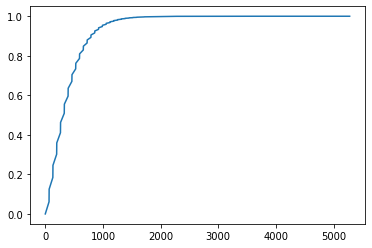

In [14]:
# if iter += 1 is used
plt.plot(res)

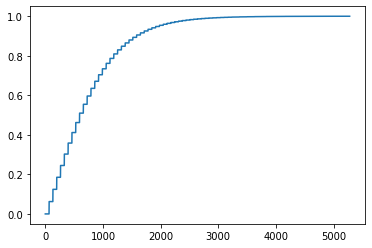

In [16]:
# if iter += 1 is not used
plt.plot(res)

In [ ]:
ds_t = HuBMAPDataset(fold=fold, train=True, tfms=get_aug())
ds_v = HuBMAPDataset(fold=fold, train=False)
data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=bs,
            num_workers=NUM_WORKERS,pin_memory=True).cuda()
model = UneXt50().cuda()
learn = Learner(data, model, loss_func=symmetric_lovasz,
            metrics=[Dice_soft(),Dice_th()], 
            splitter=split_layers, path=f'../experiments/{EXPERIMENT_NAME}').to_fp16()

Using cache found in /home/kudaibergen.abutalip/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [ ]:
learn.lr_find(stop_div=False, num_it=200)

## Fast ai training loop

In [ ]:
Learner.fit_one_cycle?

In [ ]:
dice = Dice_th_pred(np.arange(0.2,0.7,0.01))
for fold in range(1):
    ds_t = HuBMAPDataset(fold=fold, train=True, tfms=get_aug())
    ds_v = HuBMAPDataset(fold=fold, train=False)
    data = ImageDataLoaders.from_dsets(ds_t,ds_v,bs=bs,
                num_workers=NUM_WORKERS,pin_memory=True).cuda()
    model = UneXt50().cuda()
    learn = Learner(data, model, loss_func=symmetric_lovasz,
                metrics=[Dice_soft(),Dice_th()], 
                splitter=split_layers, path=f'../experiments/{EXPERIMENT_NAME}').to_fp16()
    
    #start with training the head
    learn.freeze_to(-1) #doesn't work
    for param in learn.opt.param_groups[0]['params']:
        param.requires_grad = False
    learn.fit_one_cycle(6, lr_max=0.5e-3, cbs=WandbCallback(log_preds=False))

    #continue training full model
    learn.unfreeze()
    learn.fit_one_cycle(EPOCHS, lr_max=slice(3e-4, 3e-3),
        cbs=[WandbCallback(log_preds=False), SaveModelCallback(monitor='dice_th',comp=np.greater)])
    torch.save(learn.model.state_dict(),f'../experiments/{EXPERIMENT_NAME}/model_{fold}.pth')
    
    #model evaluation on val and saving the masks
    mp = Model_pred(learn.model,learn.dls.loaders[1])
    with zipfile.ZipFile(f'../experiments/{EXPERIMENT_NAME}/val_masks_tta.zip', 'a') as out:
        for p in progress_bar(mp):
            dice.accumulate(p[0],p[1])
            save_img(p[0],p[2],out)
    gc.collect()
    wandb.finish()

In [ ]:
torch.save(learn.model.state_dict(),f'../experiments/{EXPERIMENT_NAME}/model_{fold}.pth')

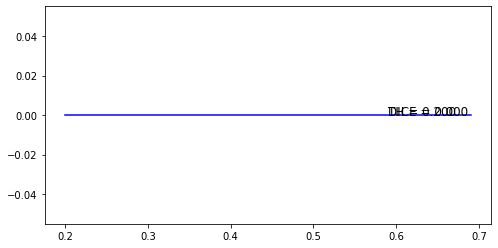

In [ ]:
dices = dice.value
noise_ths = dice.ths
best_dice = dices.max()
best_thr = noise_ths[dices.argmax()]
plt.figure(figsize=(8,4))
plt.plot(noise_ths, dices, color='blue')
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max(), colors='black')
d = dices.max() - dices.min()
plt.text(noise_ths[-1]-0.1, best_dice-0.1*d, f'DICE = {best_dice:.3f}', fontsize=12);
plt.text(noise_ths[-1]-0.1, best_dice-0.2*d, f'TH = {best_thr:.3f}', fontsize=12);
plt.show()